# Can KNN Classification Be Used to Predict Whether a Credit Card User Will Default on Their Next Bill? 
By:
Elissac Kim,
Lucia Monchi,
Rodrigo Samayoa,
Sylvain Yabre


## Introduction

The credit card system allows cardholders to borrow money from a financial institution under the agreement that the borrowed funds will be repaid by the due date, beyond which the card provider will charge an interest rate on the borrower. The borrower is required, in most cases, to pay a minimum portion of the borrowed funds by the due date. If a cardholder fails to make the minimum payment “six months”  in a row, they are said to have defaulted (Irby 2020). 

Financial institutions are always looking for ways to reduce investment risk by trying to predict which customers are likely to default due to the cost this can impose on companies.

In this report, we will create a model to attempt to predict whether a customer is going to default on their upcoming bill based on previous bill and payment history. To build this model, we are using the “default of credit card clients Data Set” found in the UCI Machine Learning Repository (Yeh & Lien, 2009). 

We will be using a K-nearest neighbour classification algorithm to try to answer our question. The data provides us with the bill and payment history of 30,000 cardholders covering September through April. These records combined with the balance limit, which is the maximum amount of money that a cardholder is allowed to borrow, will serve as our input to the algorithm.


In [23]:
#install.packages("themis")

In [24]:
#Loading needed libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
#library("themis")
set.seed(9999)

## Methods

### Load, Tidy and Split Data

The dataset used for this model includes information on sex, education, marriage, age, payment and bill history, credit limit and default status for the next month. Since we are only using bill, payment history and balance limit as our predictors we cleaned up the data accordingly by selecting the columns we need for our analysis and renaming them to make them human-readable. 

Since every customer has a different balance limit, we normalized the dataset by creating new columns that show the ratio of debt to the balance limit. In this report, we will be using these columns as the predictors in our model as they show each customers’ debt in relation to their credit limit. 

To ensure that our dataset is viable to use to create a prediction model, we used the summarize() function to get an idea of the total number of observations.

Finally, we split the data into training and testing sets so we can properly analyze, train and test the model without having the testing set influence the results. 


In [25]:
#Load dataset into Jupyter
ccData <- read_excel('data/default-cc-data.xls')  
head(ccData)

New names:
* `` -> ...1



...1,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [26]:
#Tidy data
clean_ccData = ccData %>%
    select(-c(X2:X11))%>% 
    rename(client_id = "...1", 
           limit_bal = X1,
           sep_bill = X12 , 
           aug_bill= X13 ,
           july_bill= X14,
           june_bill= X15,
           may_bill= X16, 
           april_bill=X17,
           sep_paid= X18 ,
           aug_paid= X19, 
           july_paid= X20, 
           june_paid= X21 ,
           may_paid= X22 ,
           april_paid= X23,
           default_status = Y)%>%
    slice(2:30001) %>%
    mutate_if(is.character, as.numeric) %>%
    mutate(client_id = as.character(client_id),
           default_status = case_when(default_status =="1"~"yes",
                                     default_status== "0"~"no"),
           default_status = as.factor(default_status),
           apr_debt_ratio = april_bill/limit_bal,
           may_debt_ratio = may_bill/limit_bal,
           jun_debt_ratio = june_bill/limit_bal,
           jul_debt_ratio = july_bill/limit_bal,
           aug_debt_ratio = aug_bill/limit_bal,
           sep_debt_ratio = sep_bill/limit_bal) %>%
    select(client_id, limit_bal, default_status, sep_debt_ratio : apr_debt_ratio)

head(clean_ccData)

client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,jun_debt_ratio,may_debt_ratio,apr_debt_ratio
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,yes,0.1956500,0.1551000,0.0344500,0.00000000,0.00000000,0.0000000
2,120000,yes,0.0223500,0.0143750,0.0223500,0.02726667,0.02879167,0.0271750
3,90000,no,0.3248778,0.1558556,0.1506556,0.15923333,0.16608889,0.1727667
4,50000,no,0.9398000,0.9646600,0.9858200,0.56628000,0.57918000,0.5909400
5,50000,no,0.1723400,0.1134000,0.7167000,0.41880000,0.38292000,0.3826200
6,50000,no,1.2880000,1.1413800,1.1521600,0.38788000,0.39238000,0.4004800


In [27]:
#Summary of #observartions
overall_count = clean_ccData %>%
    summarize(n = n()) 
overall_count

n
<int>
30000


In [28]:
#Split data into trainig and testing
debt_split = initial_split(clean_ccData, prop = 0.75, strata = default_status)
debt_train = training(debt_split)
debt_test = testing(debt_split)

### Summary table
Before creating a prediction model, we created a summary table of the training set to observe the balance between the individuals who defaulted on their credit cards and those who did not. We found that 77.88% of individuals did not default on their credit cards and 22.12% of individuals did. 

We attempted to balance the data using the step_upsample method in the model recipe, but we were unable to get the function to work. We initially received an error message telling us the function was deprecated, so we tried loading the Themis package with an updated version. Unfortunately, this would prevent the workflow from running further down, so we decided to run the model without balancing the data. 


`summarise()` ungrouping output (override with `.groups` argument)



default_status,n,percentage
<fct>,<int>,<dbl>
no,17523,77.88
yes,4977,22.12


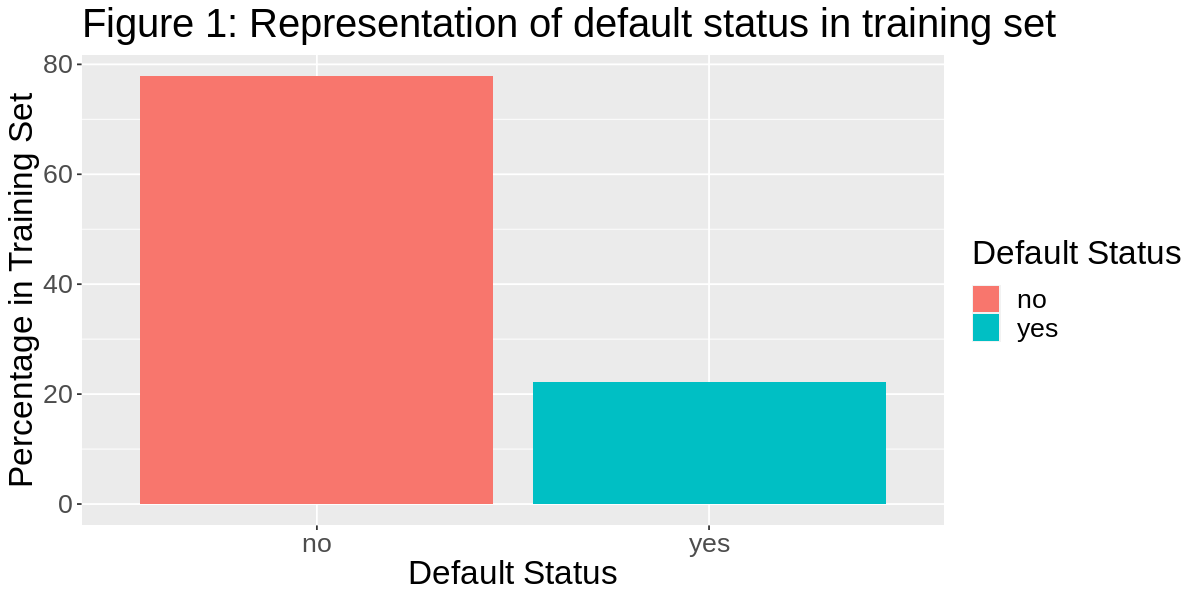

In [29]:
#Checking whether the training data is balanced or not. 
balance_count = debt_train %>%
    group_by(default_status) %>%
    summarize(n = n()) %>%
    mutate(percentage = n/nrow(debt_train)*100)
balance_count

options(repr.plot.width = 10, repr.plot.height = 5) 

plot_count = balance_count %>%
    ggplot(aes(x = default_status, y = percentage, fill = default_status)) +
    geom_bar(stat = "identity") +
    labs(x = "Default Status", 
         y = "Percentage in Training Set", 
         fill = "Default Status", 
         title = "Figure 1: Representation of default status in training set") +
    theme(text = element_text(size = 20))
plot_count

In [30]:
# Table of the information we have for each observation
default_pivot <- debt_train %>% 
select(client_id, limit_bal, default_status, apr_debt_ratio:sep_debt_ratio) %>% 
pivot_longer(cols = apr_debt_ratio:sep_debt_ratio,
                 names_to = "month",
                 values_to = "debt_ratio") 
head(default_pivot)

client_id,limit_bal,default_status,month,debt_ratio
<chr>,<dbl>,<fct>,<chr>,<dbl>
1,20000,yes,apr_debt_ratio,0.00000
1,20000,yes,may_debt_ratio,0.00000
1,20000,yes,jun_debt_ratio,0.00000
1,20000,yes,jul_debt_ratio,0.03445
1,20000,yes,aug_debt_ratio,0.15510
1,20000,yes,sep_debt_ratio,0.19565


### Debt-to-limit ratio distribution

For our initial exploration of the data, we created boxplots of the debt to limit ratio by month and by group (defaulted or not) to visualize each predictor and see if there is a pattern across months and groups. 

From the graph below, it is clear that there is a difference in the medians between the individuals that defaulted their credit cards vs. the individuals that did not, telling us that the debt-to-limit ratio could be used to predict whether a customer will default or not. 


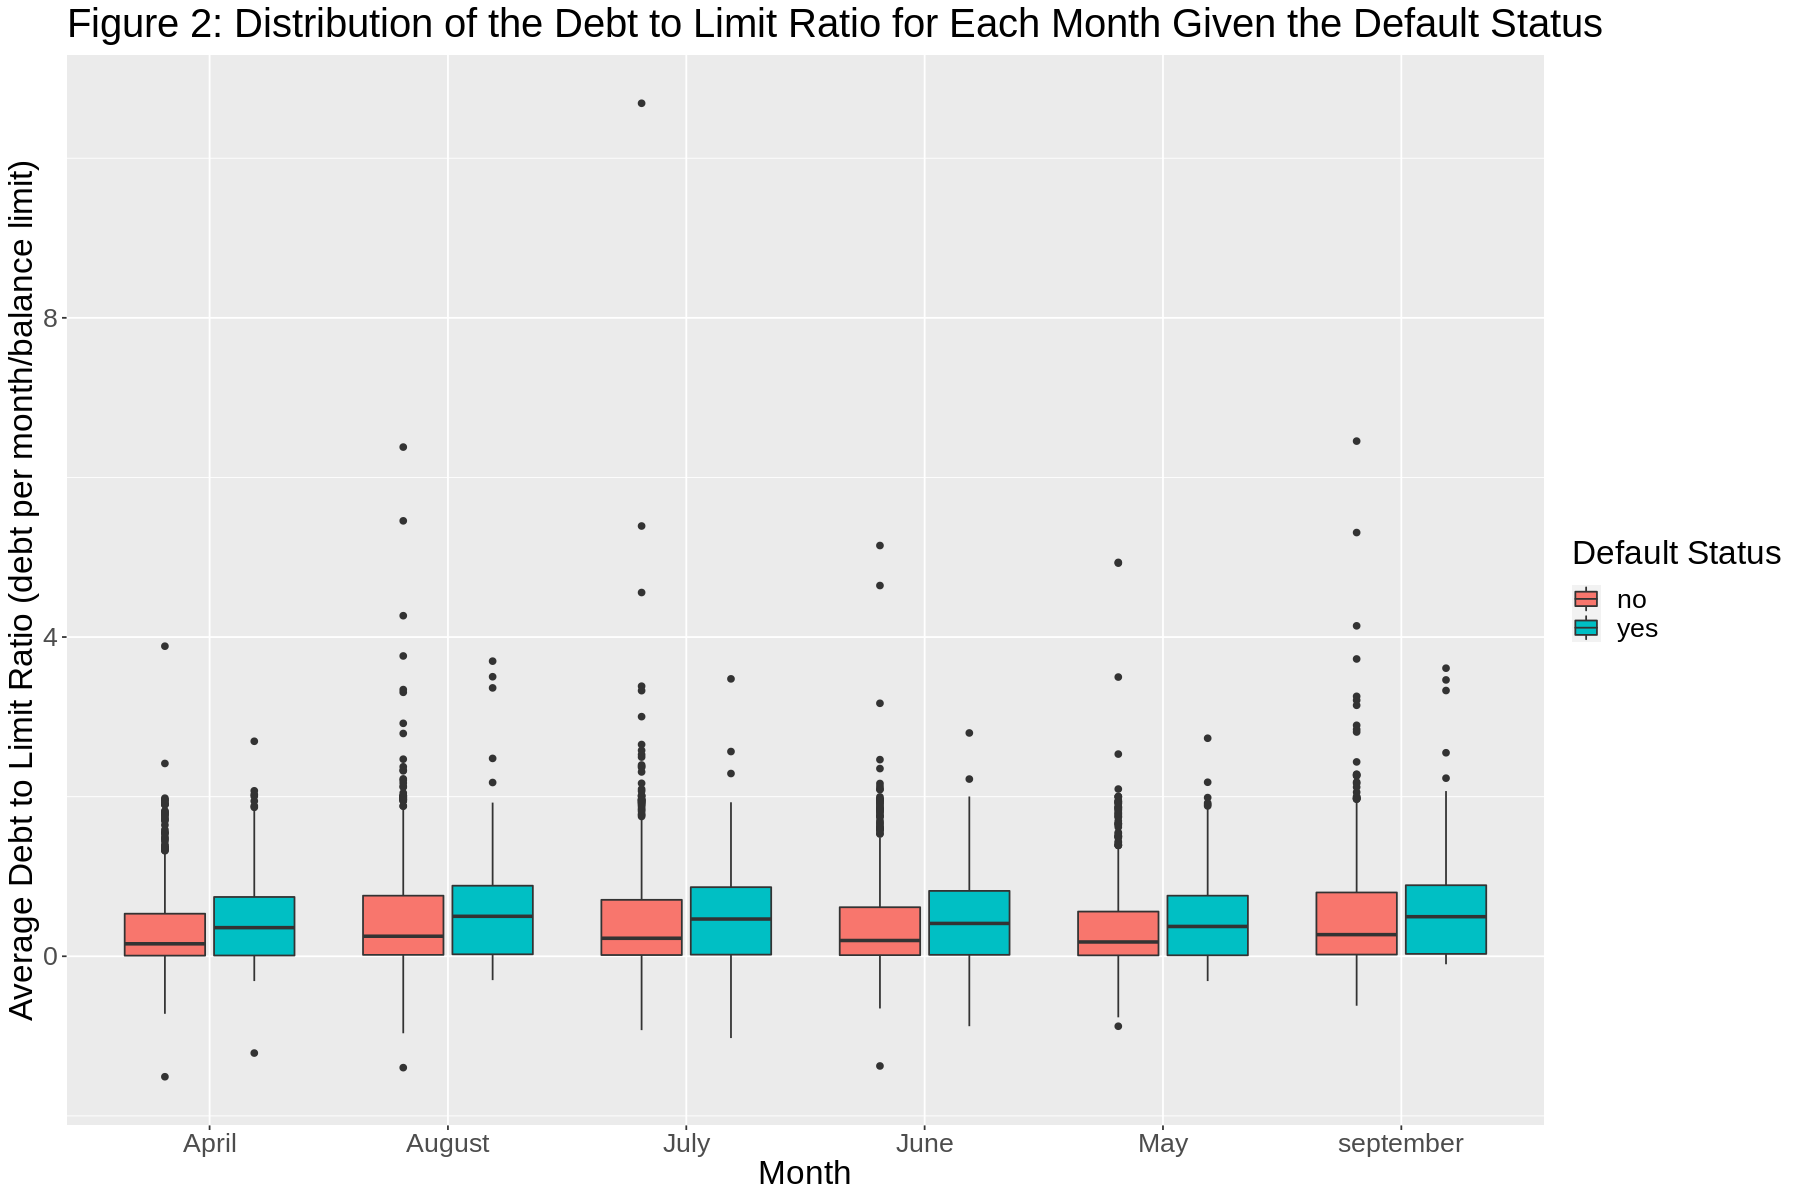

In [31]:
#Boxplot displaying the different the debt ratio distribution between people who defaulted and those who didn't

options(repr.plot.width = 15, repr.plot.height = 10)
debt_boxplot <- default_pivot %>% 
    ggplot(aes(y = debt_ratio, x = month, fill = default_status)) +
    geom_boxplot()+
    labs(y = "Average Debt to Limit Ratio (debt per month/balance limit)", 
         x = "Month", 
         fill = "Default Status",
         title = "Figure 2: Distribution of the Debt to Limit Ratio for Each Month Given the Default Status") +
    theme(text = element_text(size=20)) +
    scale_x_discrete(labels = c("apr_debt_ratio" = "April", 
                                "may_debt_ratio" =  "May", 
                                "jun_debt_ratio" = "June", 
                                "jul_debt_ratio" = "July" , 
                                "aug_debt_ratio" =  "August", 
                                "sep_debt_ratio" = "september"))
debt_boxplot

### Average debt-to-limit ratio over time

Since our theory is that those with higher debt loads are more likely to default, we need to see if there is an overall difference in debt load between those who defaulted and those who did not. To test this, we are comparing the average debt load for each group month to month to see if there is a clear difference between those who default and those who do not. This table shows that people who defaulted have a higher debt load, but, on average, their debt does not appear to increase at a faster rate.  


In [32]:
# Difference in average debt load by class
ratio_averages = debt_train %>%
    group_by(default_status) %>%
    summarize(apr_avg = mean(apr_debt_ratio),
              bmay_avg = mean(may_debt_ratio),
              cjun_avg = mean(jun_debt_ratio),
              djul_avg = mean(jul_debt_ratio),
              eaug_avg = mean(aug_debt_ratio),
              fsep_avg = mean(sep_debt_ratio)) %>%
    pivot_longer(cols = apr_avg:fsep_avg,
                 names_to = "Month",
                 values_to = "avg_debt_ratio")
ratio_averages

`summarise()` ungrouping output (override with `.groups` argument)



default_status,Month,avg_debt_ratio
<fct>,<chr>,<dbl>
no,apr_avg,0.2963724
no,bmay_avg,0.3112047
no,cjun_avg,0.3361439
no,djul_avg,0.3700840
no,eaug_avg,0.3897087
no,fsep_avg,0.4053941
yes,apr_avg,0.4020887
yes,bmay_avg,0.4152069
yes,cjun_avg,0.4428016


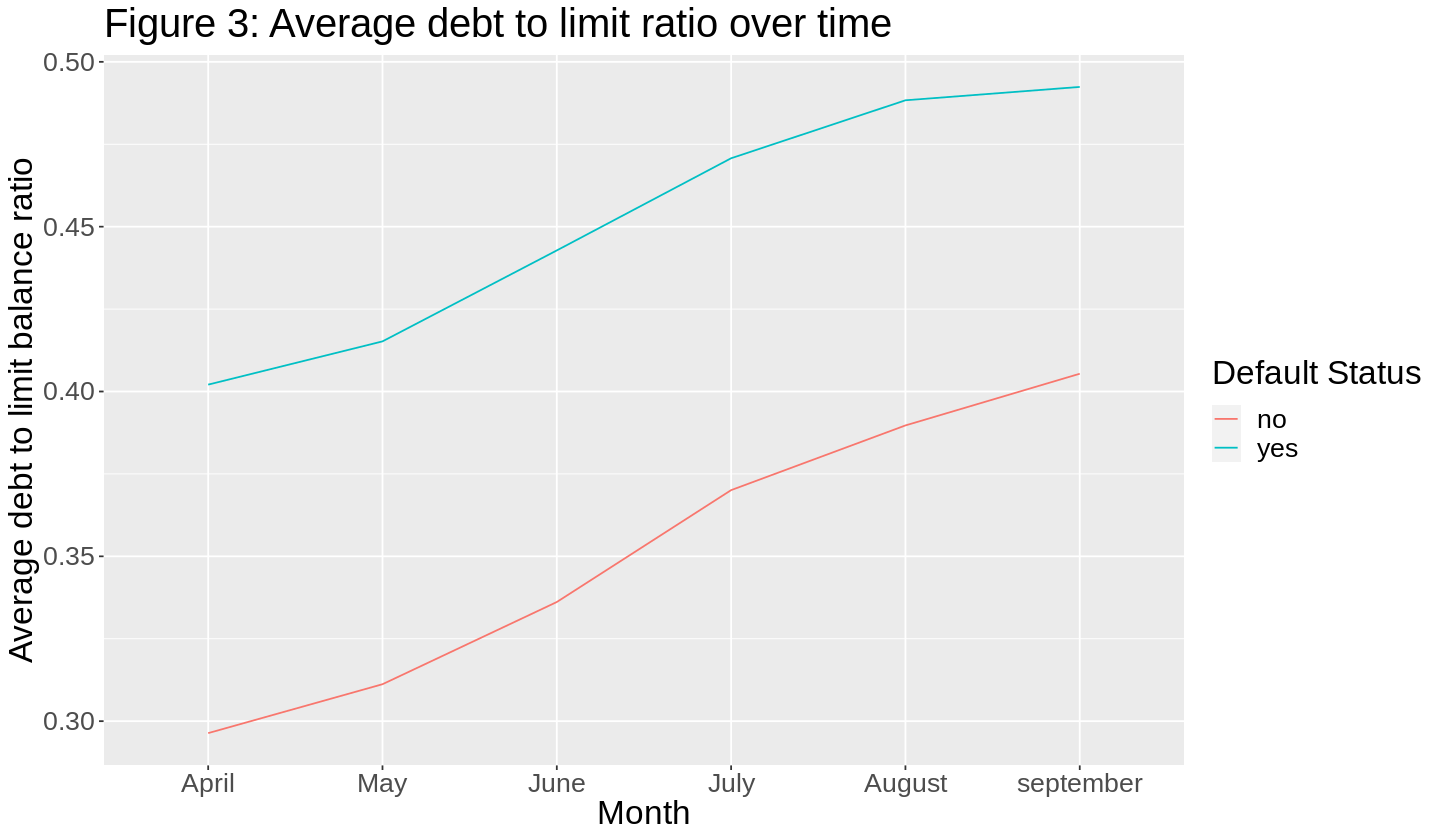

In [33]:
# Plot of the above table which plots the average debt load each month for both groups.

options(repr.plot.width = 12, repr.plot.height = 7)
debt_ratio_plot = ratio_averages %>%
    ggplot(aes(x=Month, y=avg_debt_ratio, color=default_status)) +
    geom_line(data=ratio_averages, aes(group=default_status)) +
    labs(x="Month", 
         y="Average debt to limit balance ratio", 
         color="Default Status", 
         title="Figure 3: Average debt to limit ratio over time") +
    theme(text = element_text(size=20)) +
    scale_x_discrete(labels = c("apr_avg" = "April", 
                                "bmay_avg" =  "May", 
                                "cjun_avg" = "June", 
                                "djul_avg" = "July" , 
                                "eaug_avg" =  "August", 
                                "fsep_avg" = "september"))
debt_ratio_plot

### Thesis 

Based on the results of our visual, we are hypothesizing that people with higher debt loads are more likely to default on their payments the following month. In our dataset, we do not have income information, so we are using the ratio of their bill to their credit limit as a proxy for debt load. Since we have information over a span of six months, we are using the debt-to-limit ratio for all 6 months in our prediction model so the model can measure the trend over time. 

### Prediction method 

For our prediction model, we chose to use the KNN nearest neighbours classification model as we are using quantitative values to predict a categorical value. 

### Model Recipe and Spec

The recipe for our model uses the debt to limit ratio of each month to predict the default status. As stated above, we tried using the step_usample function to balance the data, but were unsuccessful in doing so. 

Our model specification uses a knn-nearest neighbours classification model with the tune() function to find which K value will give the best accuracy for the model.

In [34]:
#Model recipe -- commented out upsample due to technical issues
debt_recipe = recipe(default_status ~ sep_debt_ratio + aug_debt_ratio 
                     + jul_debt_ratio + may_debt_ratio + apr_debt_ratio, data = debt_train) #%>%
#    step_upsample(default_status, over_ratio = 1, skip = FALSE) %>%
#    prep()

debt_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

In [35]:
debt_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
debt_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### Finding the best accuracy 

To find the best K for our classification model we applied a tuning workflow that uses the recipe and model spec created above, as well as a 5-fold cross validation. Since the default data set is very large, we chose to run every 5 K values from 1 to 100 so that we can look at a wide range of values. Finally, we used the collect_metrics() function to collect the data regarding the accuracy of the number of neighbours to use for each prediction. 

After collecting the metrics, we plotted all the values of K to find which values would give us the best accuracy. 


In [36]:
#Model tuning
debt_vfold = vfold_cv(debt_train, v=5, strata = default_status)

gridvals = tibble(neighbors = seq(1, 100, by = 5))

debt_results = workflow() %>%
    add_recipe(debt_recipe) %>%
    add_model(debt_spec) %>%
    tune_grid(resamples = debt_vfold, grid = gridvals)%>%
    collect_metrics()
head(debt_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6819996,5,0.002936633,Model01
1,roc_auc,binary,0.5279797,5,0.002509515,Model01
6,accuracy,binary,0.7451552,5,0.003101697,Model02
6,roc_auc,binary,0.5908548,5,0.005772477,Model02
11,accuracy,binary,0.7640004,5,0.001461785,Model03
11,roc_auc,binary,0.6031055,5,0.004333612,Model03


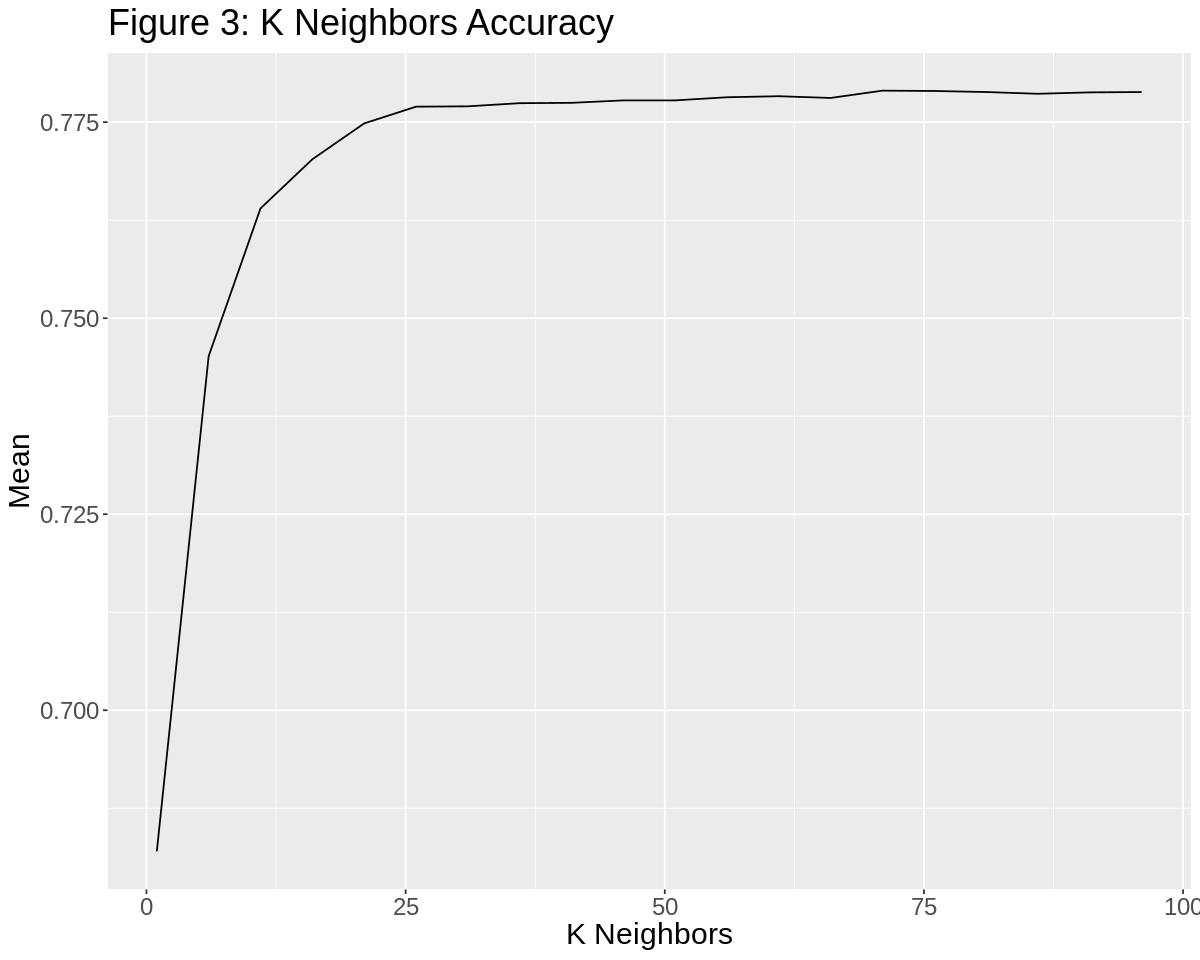

In [37]:
options(repr.plot.width = 10, repr.plot.height = 8)
vfold_plot = debt_results %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_line() +
    labs(x = "K Neighbors",
        y = "Mean",
        title = "Figure 3: K Neighbors Accuracy") +
    theme(text = element_text(size=18))
vfold_plot


### Final prediction

Based on the above graph, we decided to use K = 75 for our final prediction model, since it has a strong accuracy and is an odd number, thus helping prevent ties. We created a new model specification with K = 75 and used the same recipe as above. We then applied the model, which uses the training set as the training data, on the testing set to see how well the model predicts defaults. 


In [38]:
final_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 75) %>%
    set_engine("kknn") %>%
    set_mode("classification")

final_fit = workflow() %>%
    add_recipe(debt_recipe) %>%
    add_model(final_spec) %>%
    fit(data = debt_train)
final_fit

debt_test_predictions = predict(final_fit, debt_test) %>%
    bind_cols(debt_test)
head(debt_test_predictions)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~75, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2213333
Best kernel: rectangular
Best k: 75

.pred_class,client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,jun_debt_ratio,may_debt_ratio,apr_debt_ratio
<fct>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,6,50000,no,1.28800000,1.14138000,1.15216000,0.38788000,0.39238000,0.400480000
no,11,200000,no,0.05536500,0.04893500,0.02767500,0.01256500,0.00914000,0.018655000
no,12,260000,no,0.04715769,0.08334615,0.03833077,0.03275769,0.08571923,0.052569231
no,13,630000,no,0.01926508,0.01031746,0.01031746,0.01031746,0.01031746,0.004555556
no,14,70000,yes,0.94002857,0.96241429,0.93858571,0.95402857,0.51624286,0.527057143
no,15,250000,no,0.28354800,0.26824000,0.25424400,0.23878400,0.22750000,0.222048000


### Prediction visual
For our prediction visual, we chose to create various boxplots to visualize the accuracy of the model and the confusion matrix month to month. We believe that this visual will help us assess how well this model predicts defaults. 

Before we created our visual, we added a column to the predictions table stating if our model predicted the default status correctly or incorrectly by indicating if there were true positives (if the model predicted that an observation would default when it actually did default), false positives (if the model predicted that an observation would default when it did not actually default), true negatives, or false negatives. We also used pivot longer to have months as a variable in the prediction visual.


In [39]:
accuracy = debt_test_predictions %>%
    metrics(truth = default_status, estimate = .pred_class) 

confidence = debt_test_predictions %>%
    conf_mat(truth = default_status, estimate = .pred_class)

accuracy
confidence

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.777733333
kap,binary,0.008507682


          Truth
Prediction   no  yes
       no  5817 1643
       yes   24   16

In [40]:
debt_mutation <- debt_test_predictions %>% 
mutate(pred_results = ifelse((.pred_class == "yes") & (.pred_class == default_status), "true_pos", 
                             ifelse((.pred_class == "yes") & (.pred_class != default_status), "false_pos", 
                             ifelse((.pred_class == "no") & (.pred_class == default_status), "true_neg", 
                             ifelse((.pred_class == "no") & (.pred_class != default_status), "false_neg", NA))))) %>% 
pivot_longer(cols = apr_debt_ratio:sep_debt_ratio,
                 names_to = "month",
                 values_to = "debt_ratio")

head(debt_mutation)

.pred_class,client_id,limit_bal,default_status,pred_results,month,debt_ratio
<fct>,<chr>,<dbl>,<fct>,<chr>,<chr>,<dbl>
no,6,50000,no,true_neg,apr_debt_ratio,0.40048
no,6,50000,no,true_neg,may_debt_ratio,0.39238
no,6,50000,no,true_neg,jun_debt_ratio,0.38788
no,6,50000,no,true_neg,jul_debt_ratio,1.15216
no,6,50000,no,true_neg,aug_debt_ratio,1.14138
no,6,50000,no,true_neg,sep_debt_ratio,1.28800


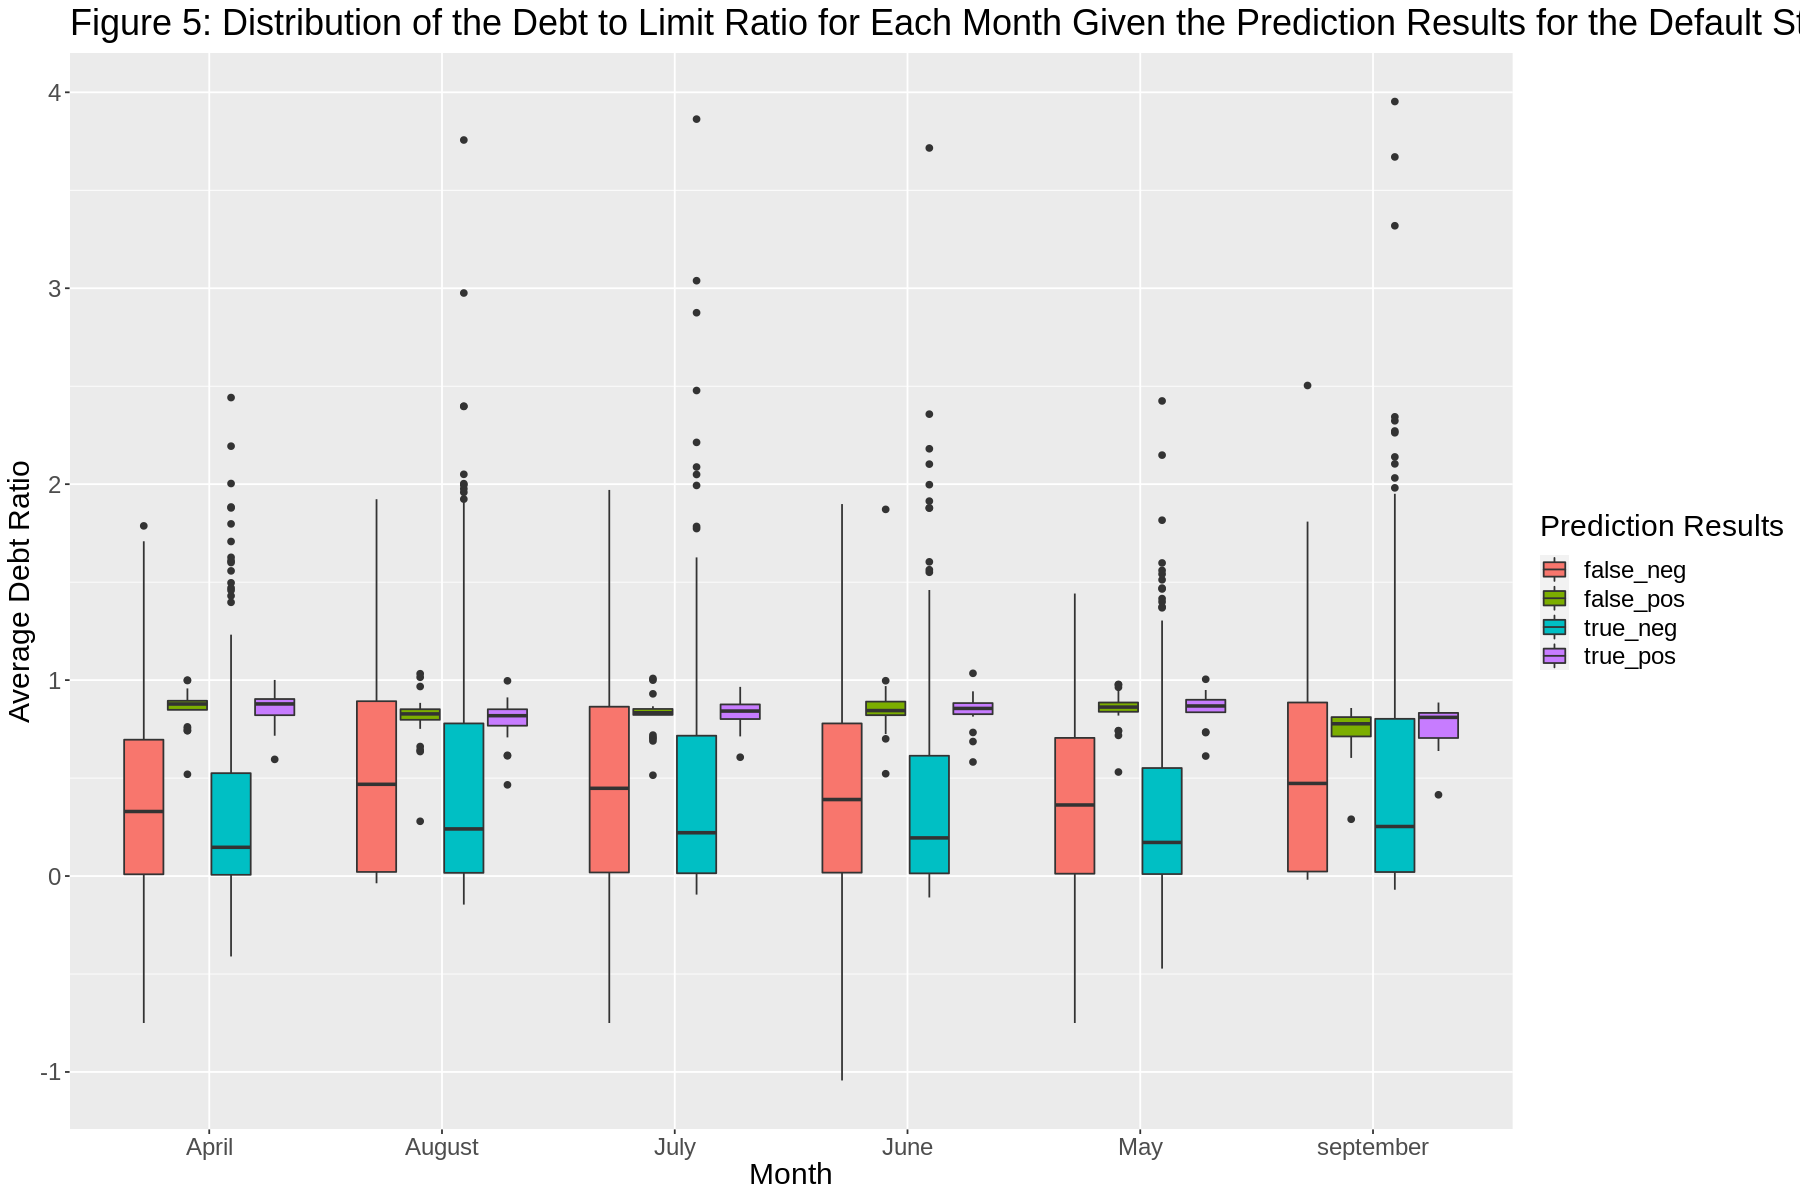

In [41]:

options(repr.plot.width = 15, repr.plot.height = 10)

prediction_plot <- debt_mutation %>% 
    ggplot(aes(y = debt_ratio, x = month, fill = pred_results)) +
    geom_boxplot()+
    labs(y = "Average Debt Ratio", 
         x = "Month", 
         fill = "Prediction Results",
         title = "Figure 5: Distribution of the Debt to Limit Ratio for Each Month Given the Prediction Results for the Default Status") +
    theme(text = element_text(size=18))+
    scale_x_discrete(labels = c("apr_debt_ratio" = "April", 
                                "may_debt_ratio" =  "May", 
                                "jun_debt_ratio" = "June", 
                                "jul_debt_ratio" = "July" , 
                                "aug_debt_ratio" =  "August", 
                                "sep_debt_ratio" = "september"))
prediction_plot

## Analysis

Before analyzing the results of our KNN prediction model, it is important to note some findings from our initial exploration above. 

### Distribution of debt ratios by group
Figure 2, The boxplot of the distribution of debt-to-limit ratios for each month, shows that those who did not default on their credit card bills have a lower median debt ratio than those who did, which coincides with our theory. We also found that the debt ratio distribution of those who did not default is greater than those who did. We see that the non-defaulting group has more outliers in the higher debt ratios, suggesting the distribution of this group skews right. 

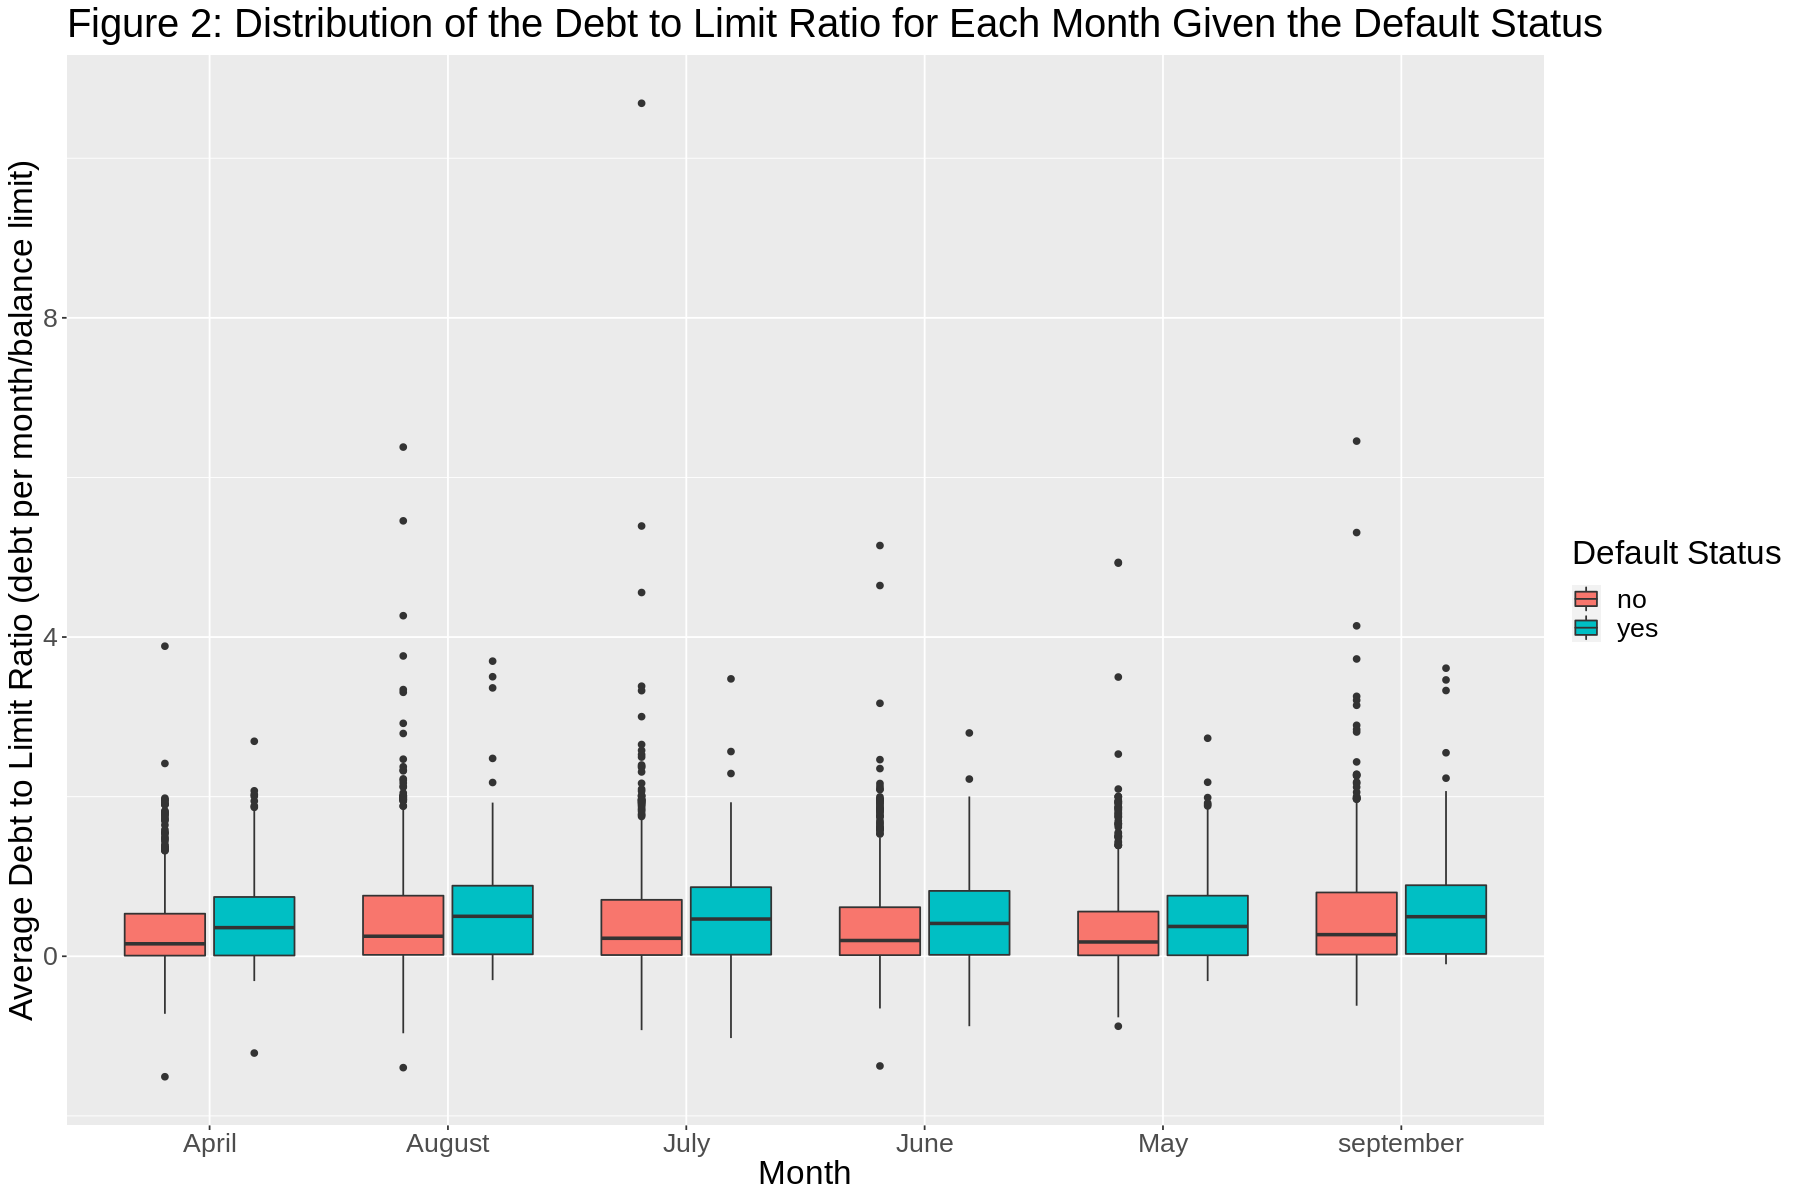

In [42]:
debt_boxplot

We found this last  point interesting as according to our theory, these individuals with high debt ratios should be in the defaulting group. With the given data, we cannot know for sure why these individuals are not defaulting as a few factors could be at play. One possible factor is that every month a segment of good-credit clients overspend and then decrease their spending over the following months to either pay off or return back to their usual credit utilization.

Another element of the data that we found interesting is that some people who ended up defaulting on their credit card actually had negative debt ratios, meaning they overpaid their credit card bills for a given month. This raises the question, how can those who default also have negative ratios? It is important to note, however, that the default_status column marks a 1 if the person defaulted on the following month, that is October. So while these customers may have had negative debt ratios during the time period of this dataset, it is possible they overspent in September and were unable to pay their October bill or ran into other financial difficulties.

As mentioned in the Methods section, one of the most significant findings of Figure 2 is that the debt ratios of those who defaulted appear to be larger than those who did not. To confirm whether this is the case and whether it was a significant difference, we looked at the average ratios by class over time. 

### Average debt ratios by month
Figure 3, the average debt-to-limit ratio over time shows that those who do not default have a debt ratio within 30%-40%, whereas those who default are within 40%-50%. The leading credit scoring metric by VantageScore, the FICO Score, recommends individuals to “keep your total credit utilization rate below 30%” (Experian, 2021). While credit utilization is just one factor influencing credit score, those who are generally conscious of their financial profile will hover around the 30% mark. 


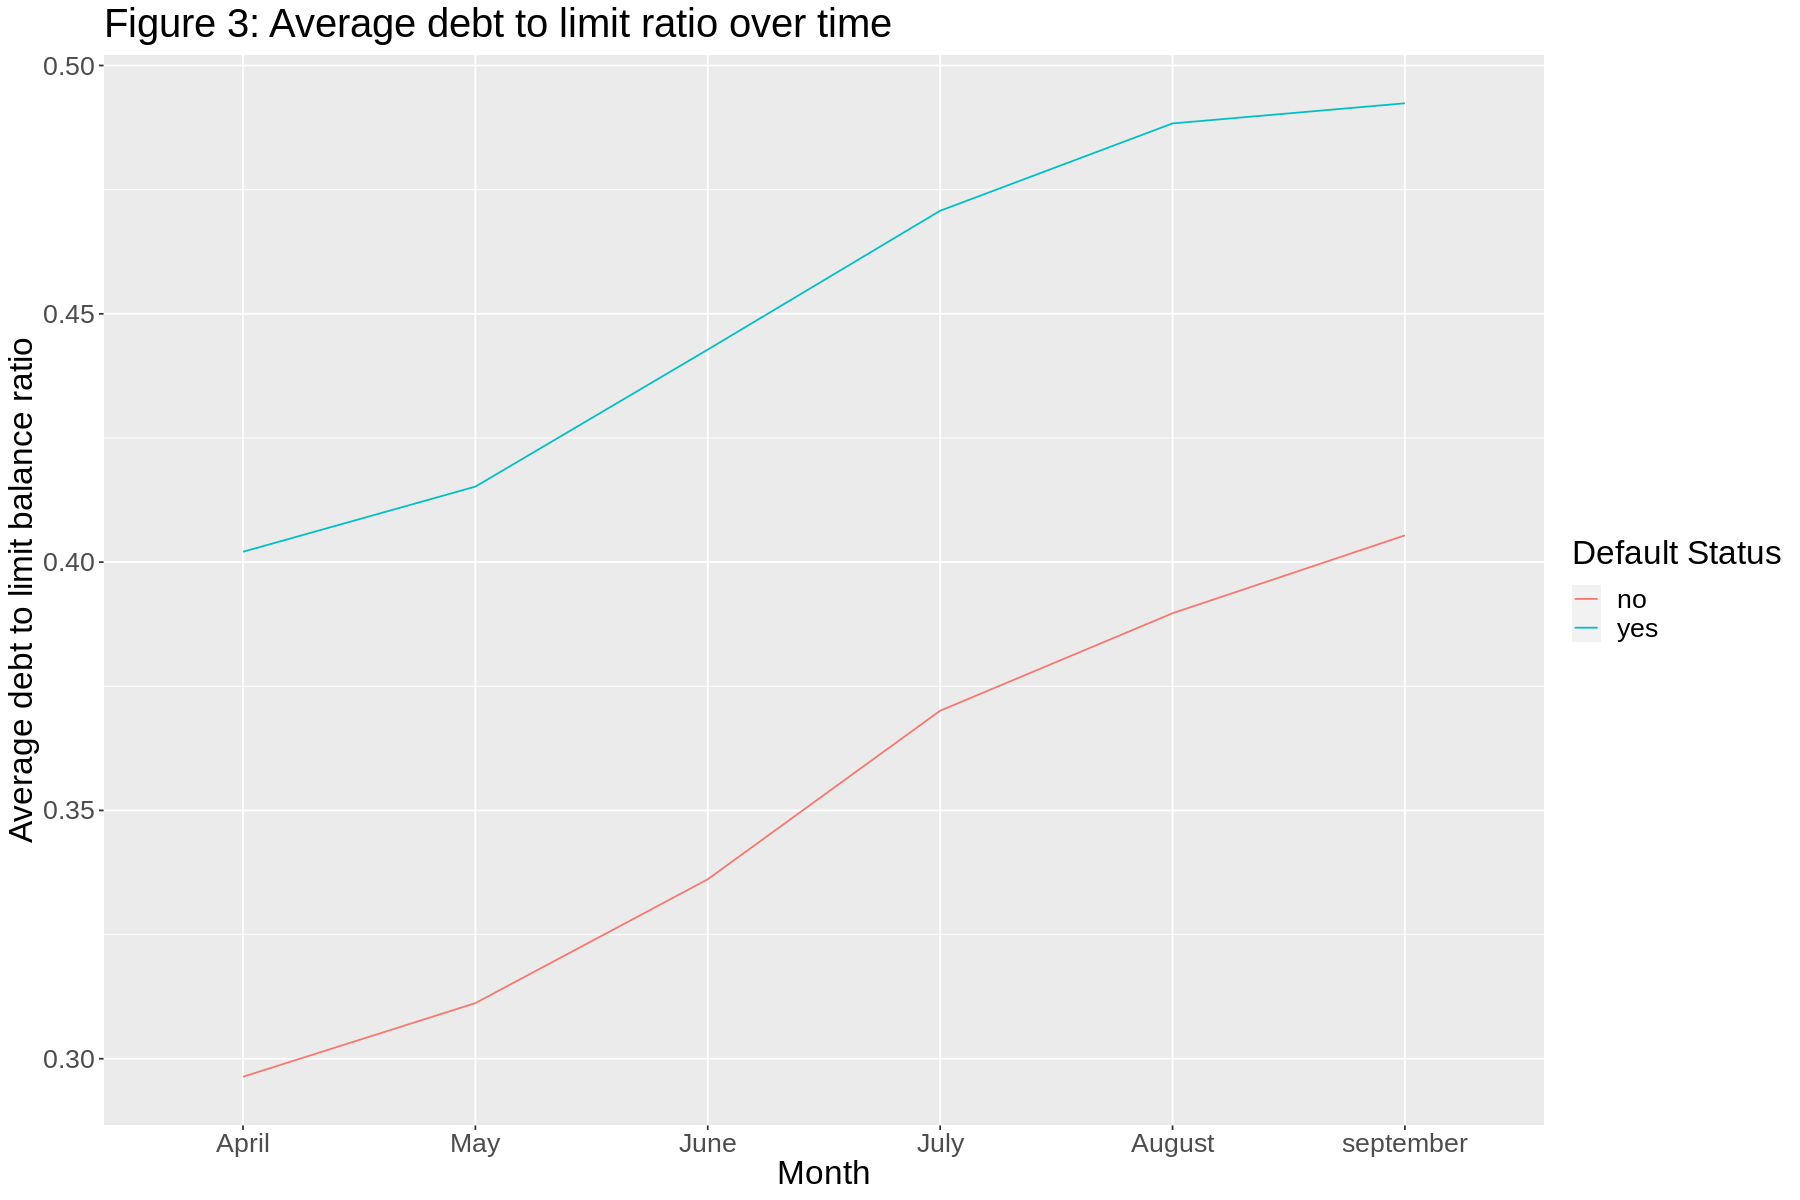

In [43]:
debt_ratio_plot

Figure 2 also shows an upward trend in average debt ratios over time for both groups. We originally expected the debt ratio of those who defaulted to increase at a faster rate, but the rate of growth appears to be similar for both groups. We believe this is due to the cyclical nature of spending habits through the year, although we cannot confirm this without looking at multi-year data. 

Second, a majority of credit-card rewards programs that incentivize registration and utilization are based on a calendar-year, rather than a 12-month basis. Therefore, many individuals will likely begin registering and utilizing more near the end of the year to claim two successive years of rewards without having to make annual fees for both years by registering in the fourth quarter. We also believe that this sudden increase can be attributed to not only an increase in credit utilization of pre-existing clients, however, the spending of new users who have a relatively lower credit balance, not justifiable by their actual income. Those who can easily make payments on their small limit will likely spend more using the card by multiple-folds. (Kerr, 2020)


### Exploring our predictions
After training the model using the debt-to-limit ratios across 6 months as predictors, we concluded the best accuracy of 0.78 resulted from K parameter of 75. However, the confusion matrix shows that our given model without up-sampling is not appropriate for predicting customers who will default. 

While the accuracy appears to be high, in reality the model predicted that 99% (7460 out of 7500) of the customers would not default. The reason the accuracy is 0.78 is that only 22% of customers defaulted on their bill. The model only accurately predicted 16 defaults, which represents 0.0096% of the customers who defaulted in the testing data. 

We can explore this through the prediction-box plot. First, the number of cases predicted positive are the smallest for each month. This is because the model was predicting nearly all cases as non-defaulting. Additionally, the false-negative boxplot is higher than the true-negative plots, and this is because the false-negative boxplots are cases that defaulted, but the model classified them as non-defaulting.

### Conclusions, Limitations & Questions: 

Given our results, we found that the K-NN algorithm is not the best model that can effectively predict whether a customer will default given the information in this dataset. The main reason for this is that this is a time series dataset that has information from month to month. The possibility of default cannot be made based on one month of financial data, as credit scores and client profiles are derived from their performance over time. This dataset requires a more advanced model that can take into account the trends of the data over time. 

Two primary questions we were left with are the following:
1. In what ways can users be stratified to make models for practical use in the banking industry?
2. What prediction models can base predictions on temporal/consistent performance? (In our case, spending behaviour over time)


## References

Experian. (2021, April). What is a credit utilization rate?. Experian. https://www.experian.com/blogs/ask-experian/credit-education/score-basics/credit-utilization-rate/    

Irby, Latoya. (2020, February 10). What You Can Do About Credit Card Default. The Balance. https://www.thebalance.com/what-is-credit-card-default-960209#:~:text=Credit%20card%20default%20happens%20when,for%20other%20credit%2Dbased%20services

Kerr, R.(2020, November 27). Why the end of the year is a great time to get a premium credit card. The Points Guy. https://thepointsguy.com/2016/10/end-of-year-add-premium-credit-card/ 